# Exercise of transfer Learning on New Data Set

## 0. Initial configuration: Loading libraries and data.

First, we import the packages we need and the vgg16 model.

In [2]:
import numpy as np
import os
import time

from keras.preprocessing import image
from keras_applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#from vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

We set the path for our new data: data2 (100 images of four classes: airplanes, birds, cars, trucks). This dataset is a subset of original dataset STL 10.


In [8]:
#%% Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/data2'
data_dir_list = os.listdir(data_path)

We load the data 

In [9]:
img_data_list=[] # created an empty list for images to be loaded

for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
		print('Input image shape:', x.shape)
		img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-airplanes

Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Loaded the images of dataset-birds

Input image shape: (1, 2

We define the labels for each image, according to the order they have been uploaded. 

In [10]:
# Define the number of classes
num_classes = 4
print(img_data.shape[0])
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['airplanes','birds','cars','trucks']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


100


We look at a summary of the vgg16 model, which we are using as base.

In [11]:
image_input = Input(shape=(224, 224, 3)) # shape of a single image

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet') # load VGG-16 model with 'top = true'
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## 1. Using vgg16 for Feature Extraction

We take the last layer and we configurate our model for feature selection (custom_vgg_model).


In [12]:
last_layer = model.get_layer('fc2').output # Take the last layer
#x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

custom_vgg_model.layers[3].trainable
custom_vgg_model.summary()

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We train the custom_vgg_model with epochs=3.

In [16]:
t=time.time()
#	t = now()
hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=3, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 80 samples, validate on 20 samples
Epoch 1/3
80/80 [==============================] - 58s - loss: 0.7808 - acc: 0.7125 - val_loss: 1.9319e-05 - val_acc: 1.0000
Epoch 2/3
80/80 [==============================] - 56s - loss: 3.4687e-05 - acc: 1.0000 - val_loss: 1.9182e-05 - val_acc: 1.0000
Epoch 3/3
80/80 [==============================] - 57s - loss: 3.4389e-05 - acc: 1.0000 - val_loss: 1.9033e-05 - val_acc: 1.0000
Training time: -172.89416217803955
20/20 [==============================] - 11s    
[INFO] loss=0.0000, accuracy: 100.0000%


We plot the accuracy and the loss as a function of the number of epochs. 
In this particular example, since the dataset is so small, we see that only after one iteration the accuracy and loss converged, to 1 and zero respectively.

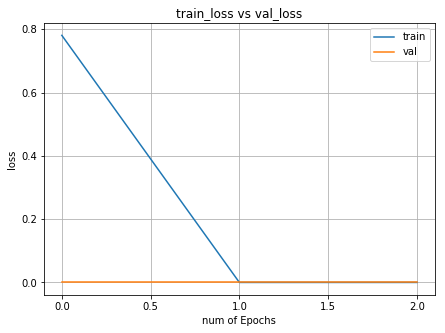

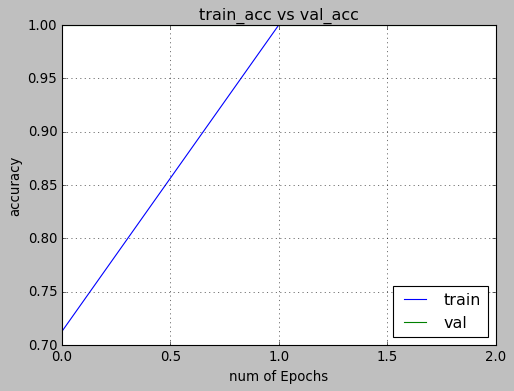

In [18]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(3)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

We see that only after one iteration the accuracy and loss converged, to 1 and zero respectively.

## 2. Using vgg16 for Fine Tunning

Now, instead of taking the last layer, we take from block5_pool (We flatten and then we train the last 2 layers).

In [19]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x) # Haw many neurons go in each layer
x = Dense(128, activation='relu', name='fc2')(x) # fc1 and fc2 are fully connected
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

# I train the 2 last layers with my data, the number of trainable parameters is 
# significantly smaller than the original model by when doing this 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
# We freeze all the layers except the dense layers (last 2 layers)
for layer in custom_vgg_model2.layers[:-3]: ## In the original model.
	layer.trainable = False

custom_vgg_model2.summary()

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We train our custom_vgg_model2 with epochs=6.

In [28]:
t=time.time()
#	t = now()
hist = custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=6, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 80 samples, validate on 20 samples
Epoch 1/6
80/80 [==============================] - 56s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/6
80/80 [==============================] - 57s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/6
80/80 [==============================] - 55s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/6
80/80 [==============================] - 57s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/6
80/80 [==============================] - 60s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/6
80/80 [==============================] - 57s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Training time: -345.8768198490143
20/20 [==============================] - 12s    
[INFO] loss=0.0000, accuracy: 100.0000%


We plot the loss and accuracy as a function of the epochs. In this case both converged in the first iteration, so the plots show a constant value. 

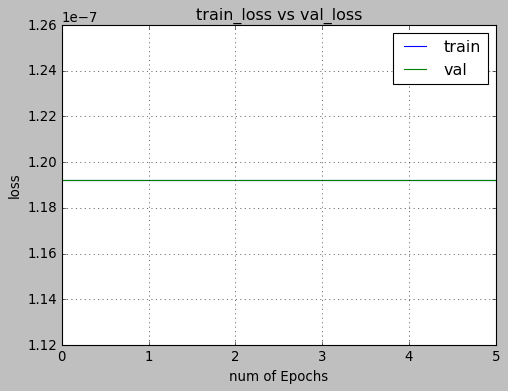

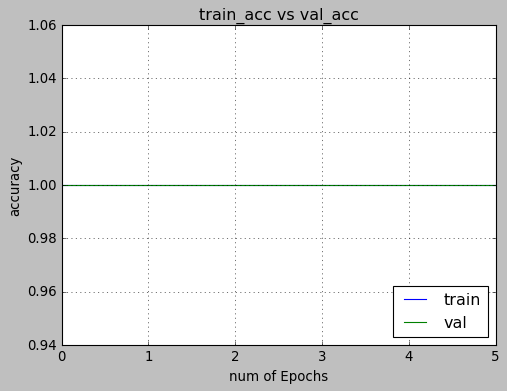

In [26]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(6)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])